## Using Histogram of Gradients (HOG) to detect vehicles in videos


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 23 23:17:00 2017
Initial upload Mon Oct 31
Detects vehicles in a video and draws bounding boxes. Outputs video.

Todo: 
1. Optimize for speed. Target is realtime detection.
2. Integrate the lane detection and drawing system 
3. Move to standard Python for modularity

@author: Henry Yau
"""
# imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

#Helper functions for creating features
from hog_helper import *

#Pickle the model and parameters once it is learned
import pickle


In [2]:
train_SVC_b = False

if train_SVC_b == True:
    """Perform feature extraction and training"""
    # Read in car and non-car images
    cars = glob.glob('./data/vehicles/**/*.png')
    notcars = glob.glob('./data/non-vehicles/**/*.png')

    spatial = 32
    histbin = 32

    #Number of orientation bins.
    orient = 9
    #Size (in pixels) of a cell.
    #pixels_per_cell : 2-tuple (int, int), optional
    pix_per_cell = 8

    #Number of cells in each block.
    #cells_per_block : 2-tuple (int, int), optional
    cell_per_block = 2

    print('Extracting car feature')
    car_features = extract_features(cars, cspace='YCrCb', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256), orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
    print('Extracting non-car feature')
    notcar_features = extract_features(notcars, cspace='YCrCb', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256), orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

    print('Scaling feature vector')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    print('Labeling and splitting train/test data')
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using ', spatial, ' spatial bins and', histbin,' histogram bins')
    print('HOG using ', orient,' orientation bins with ', pix_per_cell,'^2 pixels per cell and ', cell_per_block, '^2 cells per block')

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    t=time.time()
    svc.fit(X_train, y_train)
    # Check the training time for the SVC
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC.')

In [3]:
if train_SVC_b == True:
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [4]:
#Save things in a Pickle
if train_SVC_b == True:
    data_pickle = {
        'svc': svc,
        'scaler': X_scaler,
        'orient': orient,
        'pix_per_cell': pix_per_cell,
        'cell_per_block': cell_per_block,
        'spatial_size': spatial,
        'hist_bins': histbin
    }
    with open('svc_data_short.p', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data_pickle, f, pickle.HIGHEST_PROTOCOL)

    dist_pickle = pickle.load( open("svc_data_short.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial = dist_pickle["spatial_size"]
    histbin = dist_pickle["hist_bins"]



In [5]:
if train_SVC_b == False:
    #load pickled data
    dist_pickle = pickle.load( open("svc_data_short.p", "rb" ) )

    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial = dist_pickle["spatial_size"]
    histbin = dist_pickle["hist_bins"]

C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


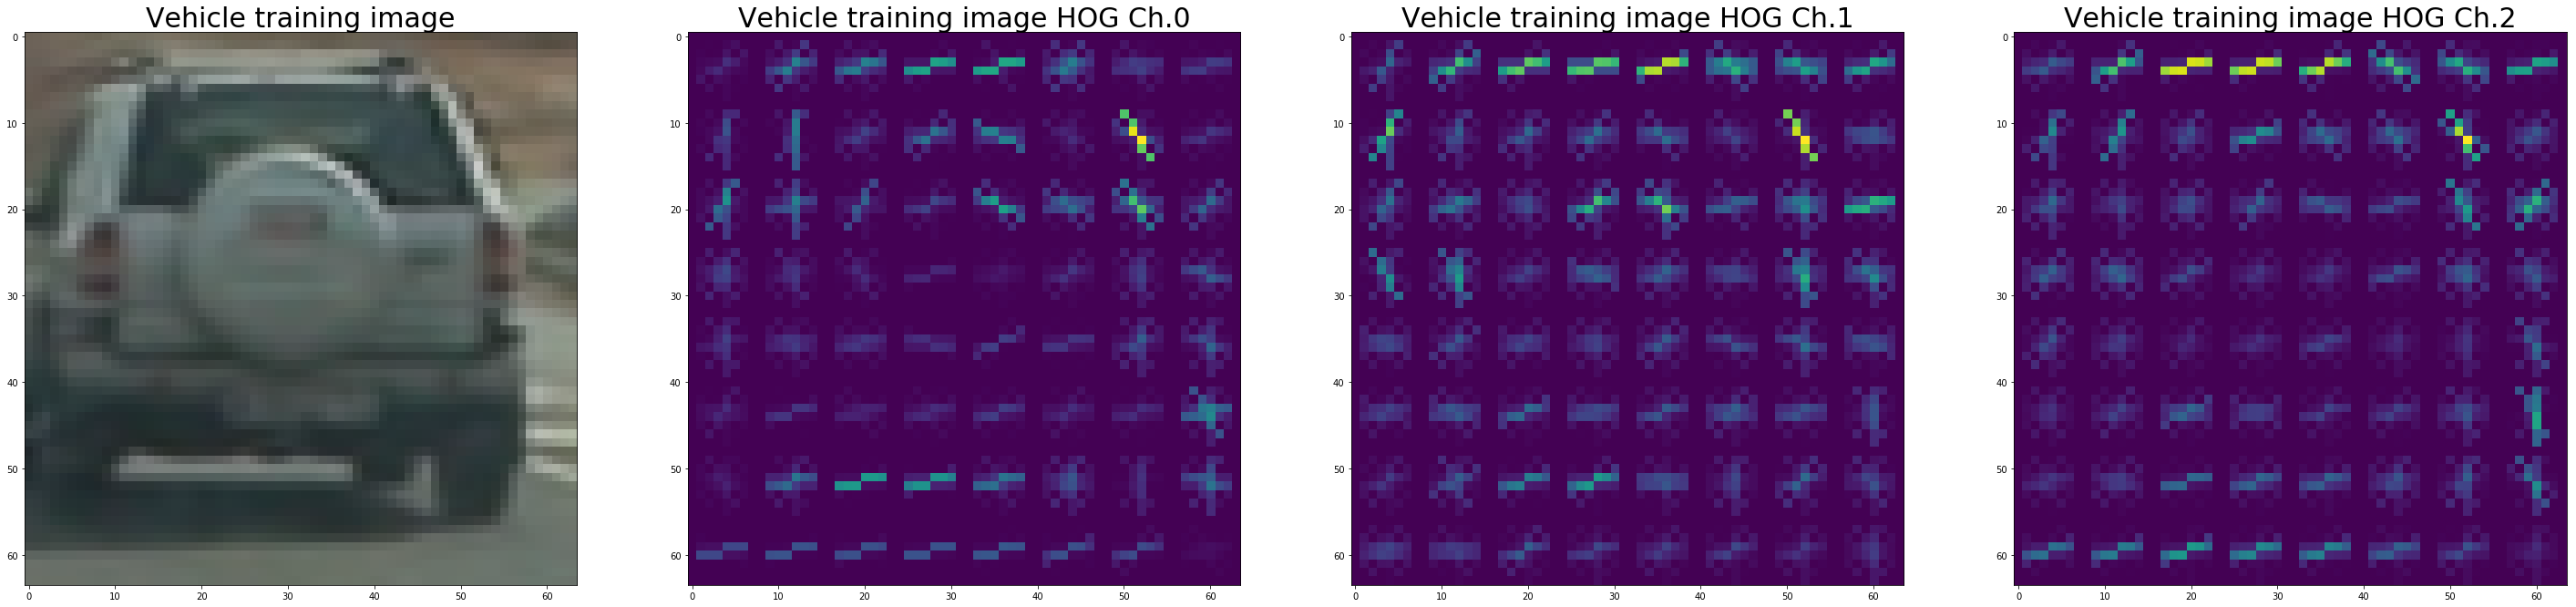

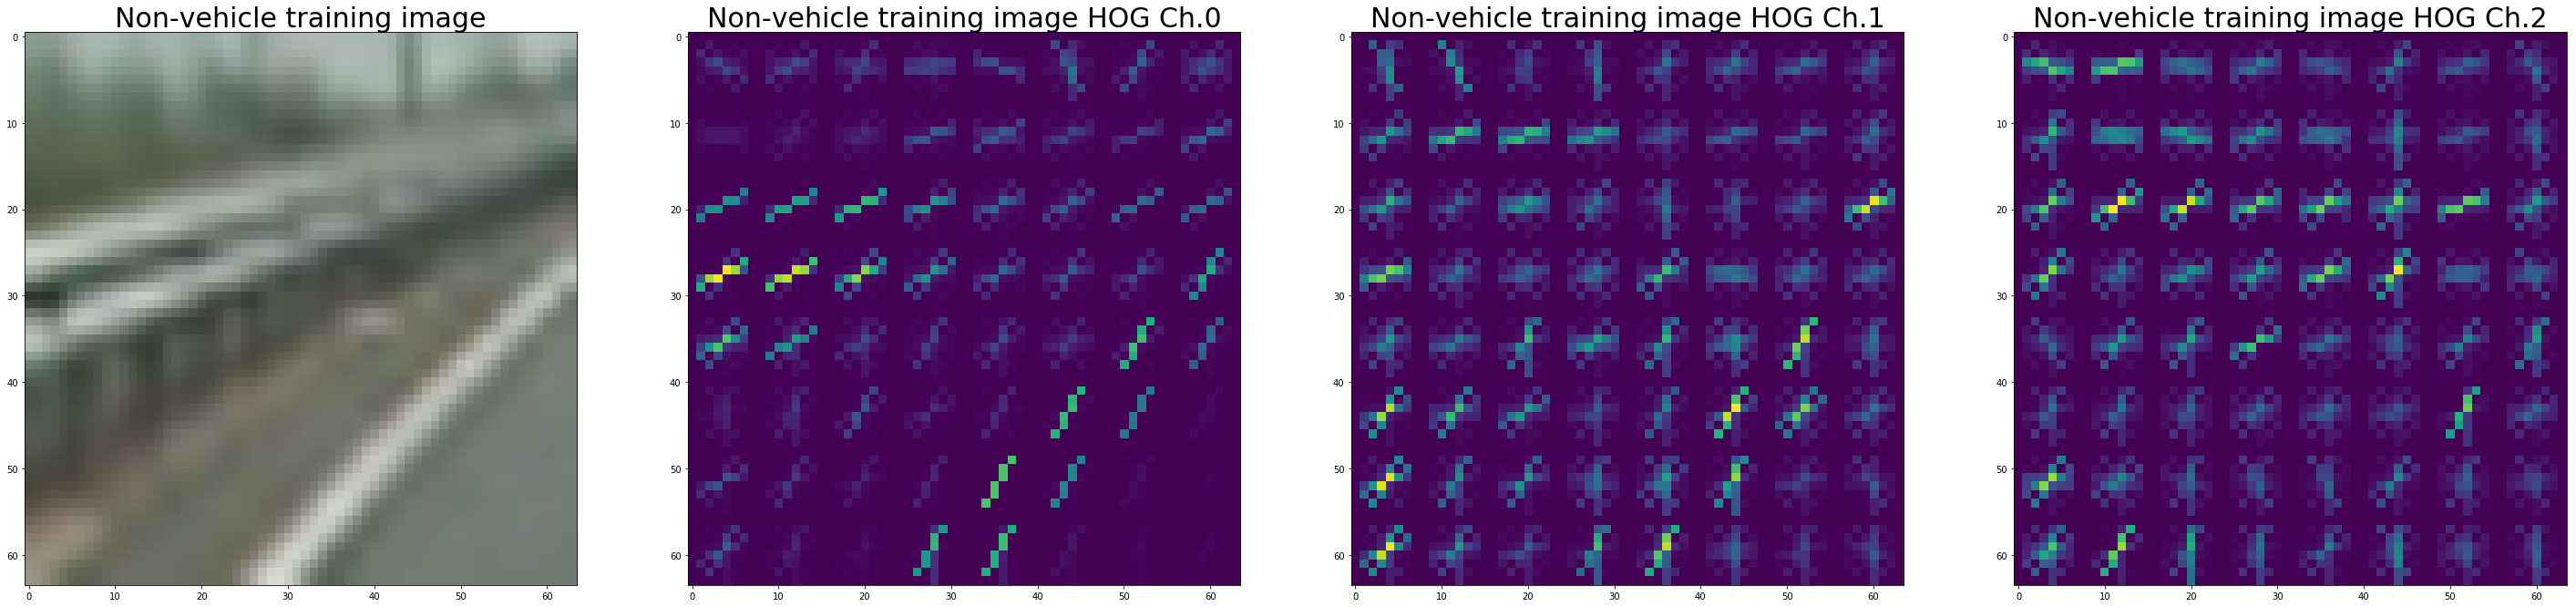

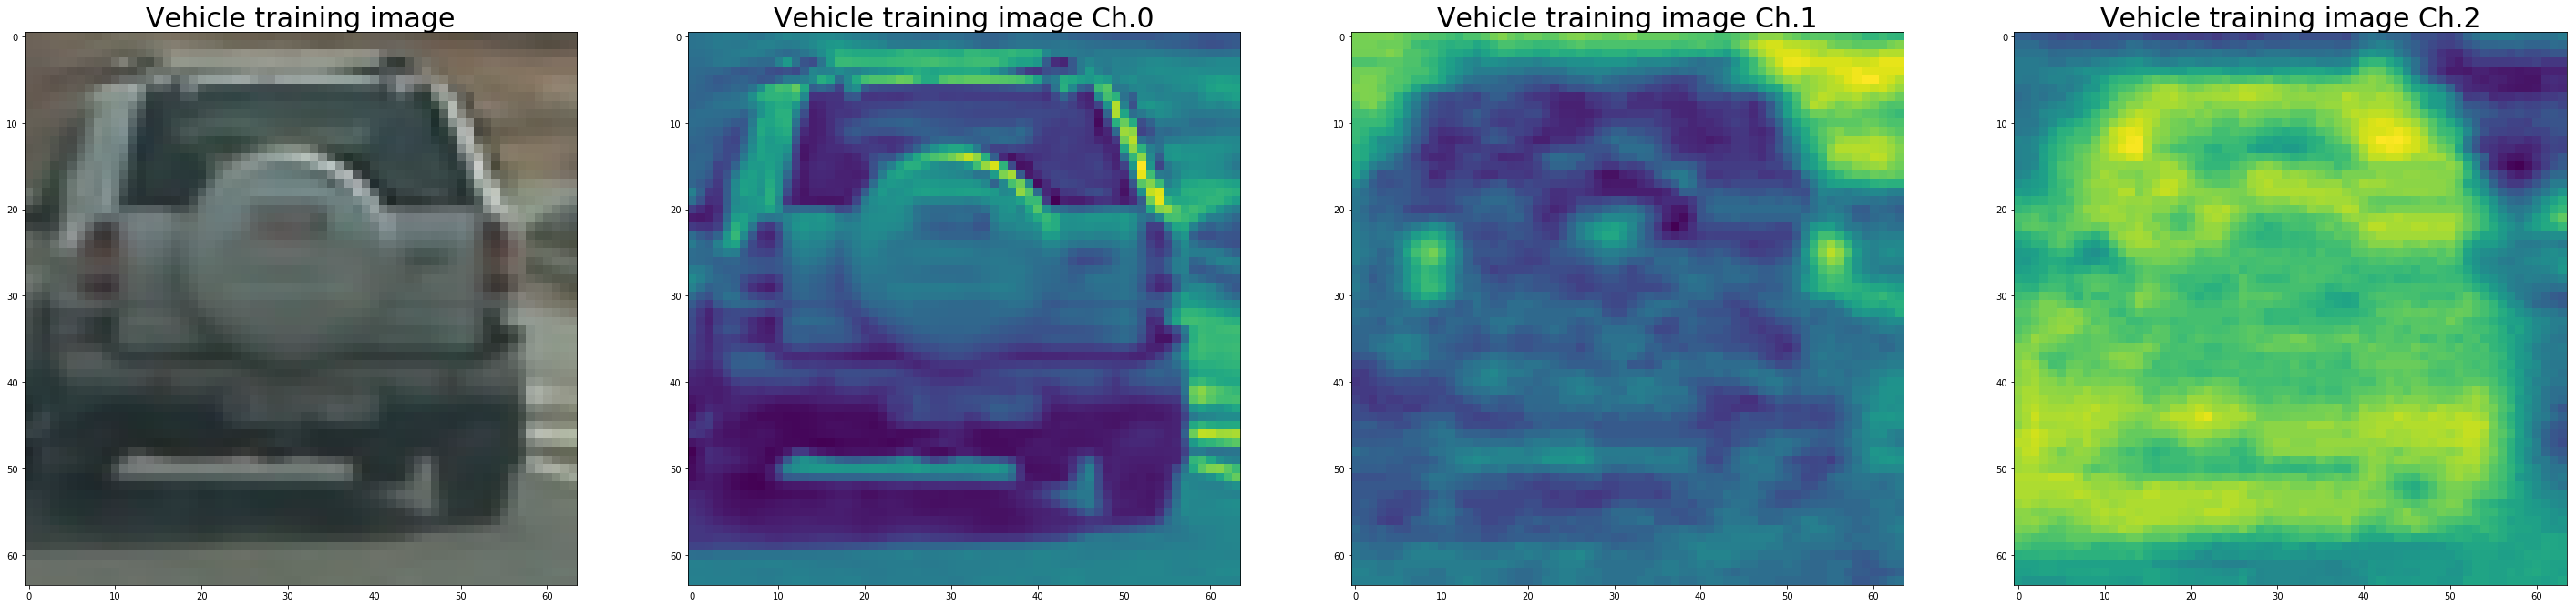

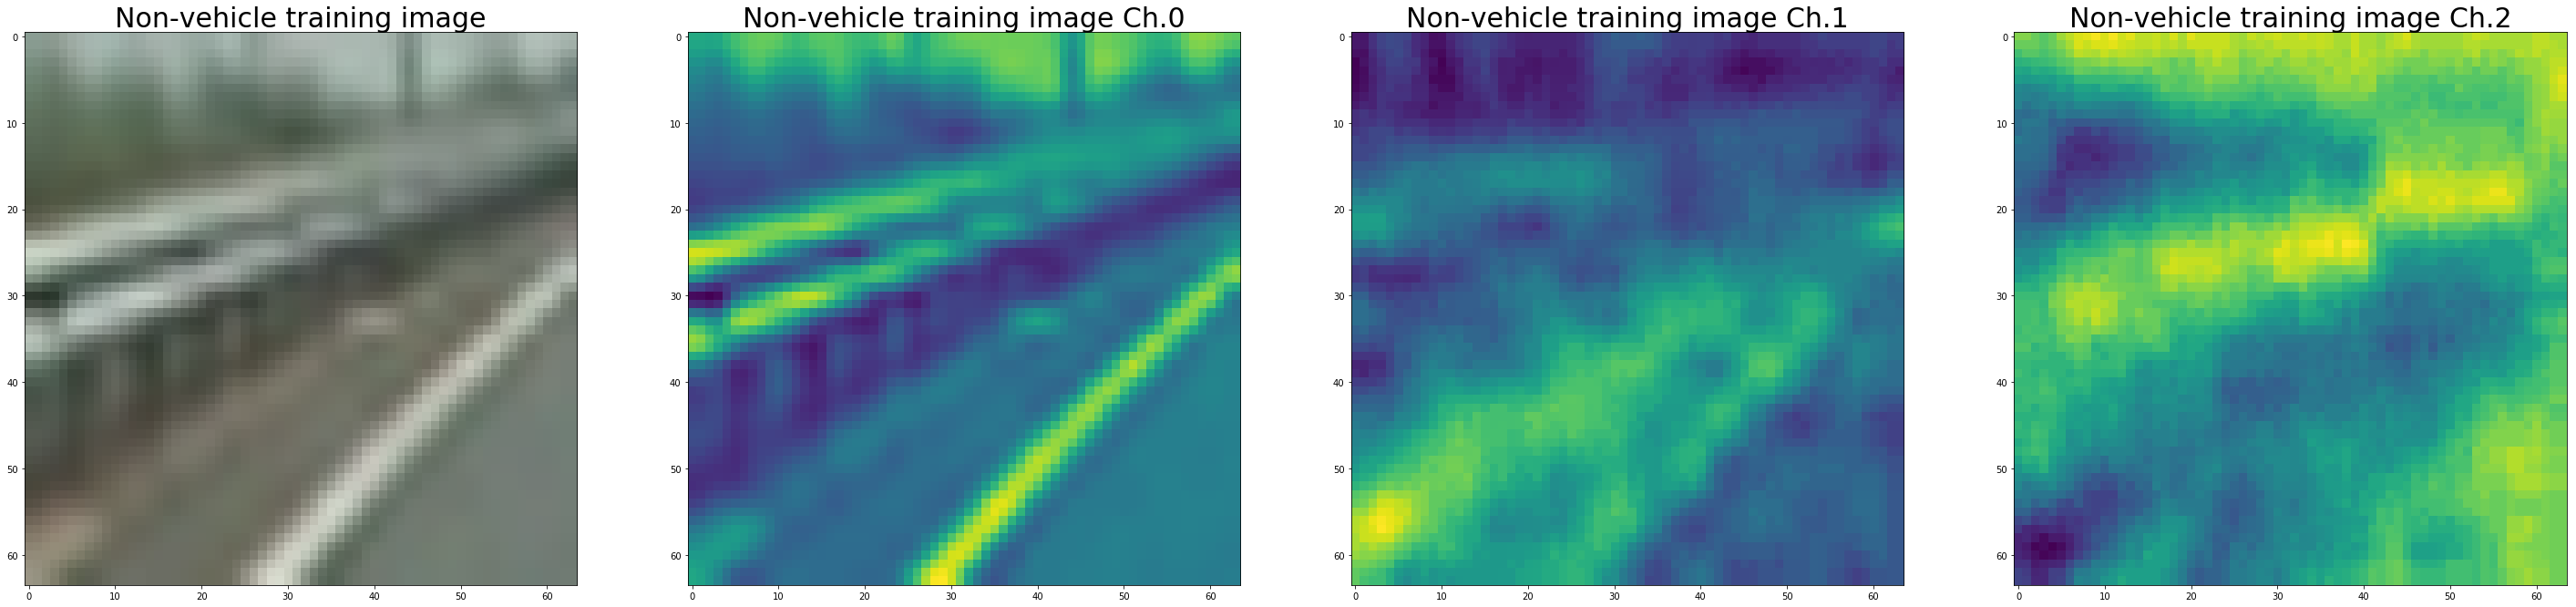

In [6]:
#demonstrate the HOG 
#generate a few images for readme
car_test_img = mpimg.imread('./data/vehicles/GTI_MiddleClose/image0066.png')
notcar_test_img =  mpimg.imread('./data/non-vehicles/GTI/image8.png')

car_test_img_YCrCb = convert_color(car_test_img, conv='RGB2YCrCb')
notcar_test_img_YCrCb = convert_color(notcar_test_img, conv='RGB2YCrCb')

hog_test, hog_testv0_img = get_hog_features(car_test_img_YCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)
hog_test, hog_testv1_img = get_hog_features(car_test_img_YCrCb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)
hog_test, hog_testv2_img = get_hog_features(car_test_img_YCrCb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)

hog_test, hog_testnv0_img = get_hog_features(notcar_test_img_YCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)
hog_test, hog_testnv1_img = get_hog_features(notcar_test_img_YCrCb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)
hog_test, hog_testnv2_img = get_hog_features(notcar_test_img_YCrCb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)


#plot car and hog, and maybe the other features

plt.figure(figsize = (50,50))

plt.subplot(1, 4, 1)
plt.imshow(car_test_img)
plt.title('Vehicle training image',fontsize=30)
plt.subplot(1, 4, 2)
plt.imshow(hog_testv0_img)
plt.title('Vehicle training image HOG Ch.0',fontsize=30)
plt.subplot(1, 4, 3)
plt.imshow(hog_testv1_img)
plt.title('Vehicle training image HOG Ch.1',fontsize=30)
plt.subplot(1, 4, 4)
plt.imshow(hog_testv2_img)
plt.title('Vehicle training image HOG Ch.2',fontsize=30)
plt.show()


plt.figure(figsize = (50,50))

plt.subplot(1, 4, 1)
plt.imshow(notcar_test_img)
plt.title('Non-vehicle training image',fontsize=30)
plt.subplot(1, 4, 2)
plt.imshow(hog_testnv0_img)
plt.title('Non-vehicle training image HOG Ch.0',fontsize=30)
plt.subplot(1, 4, 3)
plt.imshow(hog_testnv1_img)
plt.title('Non-vehicle training image HOG Ch.1',fontsize=30)
plt.subplot(1, 4, 4)
plt.imshow(hog_testnv2_img)
plt.title('Non-vehicle training image HOG Ch.2',fontsize=30)
plt.show()


plt.figure(figsize = (50,50))

plt.subplot(1, 4, 1)
plt.imshow(car_test_img)
plt.title('Vehicle training image',fontsize=30)
plt.subplot(1, 4, 2)
plt.imshow(car_test_img_YCrCb[:,:,0])
plt.title('Vehicle training image Ch.0',fontsize=30)
plt.subplot(1, 4, 3)
plt.imshow(car_test_img_YCrCb[:,:,1])
plt.title('Vehicle training image Ch.1',fontsize=30)
plt.subplot(1, 4, 4)
plt.imshow(car_test_img_YCrCb[:,:,2])
plt.title('Vehicle training image Ch.2',fontsize=30)
plt.show()

plt.figure(figsize = (50,50))

plt.subplot(1, 4, 1)
plt.imshow(notcar_test_img)
plt.title('Non-vehicle training image',fontsize=30)
plt.subplot(1, 4, 2)
plt.imshow(notcar_test_img_YCrCb[:,:,0])
plt.title('Non-vehicle training image Ch.0',fontsize=30)
plt.subplot(1, 4, 3)
plt.imshow(notcar_test_img_YCrCb[:,:,1])
plt.title('Non-vehicle training image Ch.1',fontsize=30)
plt.subplot(1, 4, 4)
plt.imshow(notcar_test_img_YCrCb[:,:,2])
plt.title('Non-vehicle training image Ch.2',fontsize=30)
plt.show()

In [7]:
#%%
#Use SVC classifier with a moving window
spatial_size = (spatial, spatial)
hist_bins = histbin

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, output_img_b = True):
    """Finds vehicles in image using a sliding moving window.
    if output_img_b == True, output image with the original image with bounding box as well as a heatmap 
    else return just the heatmap
    """
    
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    
    #also search with different window sizes
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 3  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    box_list = []
    
    # Compute Y-channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            hog_features = np.hstack((hog_feat1))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if output_img_b == True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                box_list.append(np.array([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]))
    
    
    heatmap_img = np.zeros_like(draw_img[:,:,0])
    add_heat(heatmap_img, box_list)
    if output_img_b == True:
        return draw_img, heatmap_img
    else:
        return heatmap_img
    #return draw_img, hog1_img, hog2_img, hog3_img
    


C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


6.2 Seconds to train SVC.


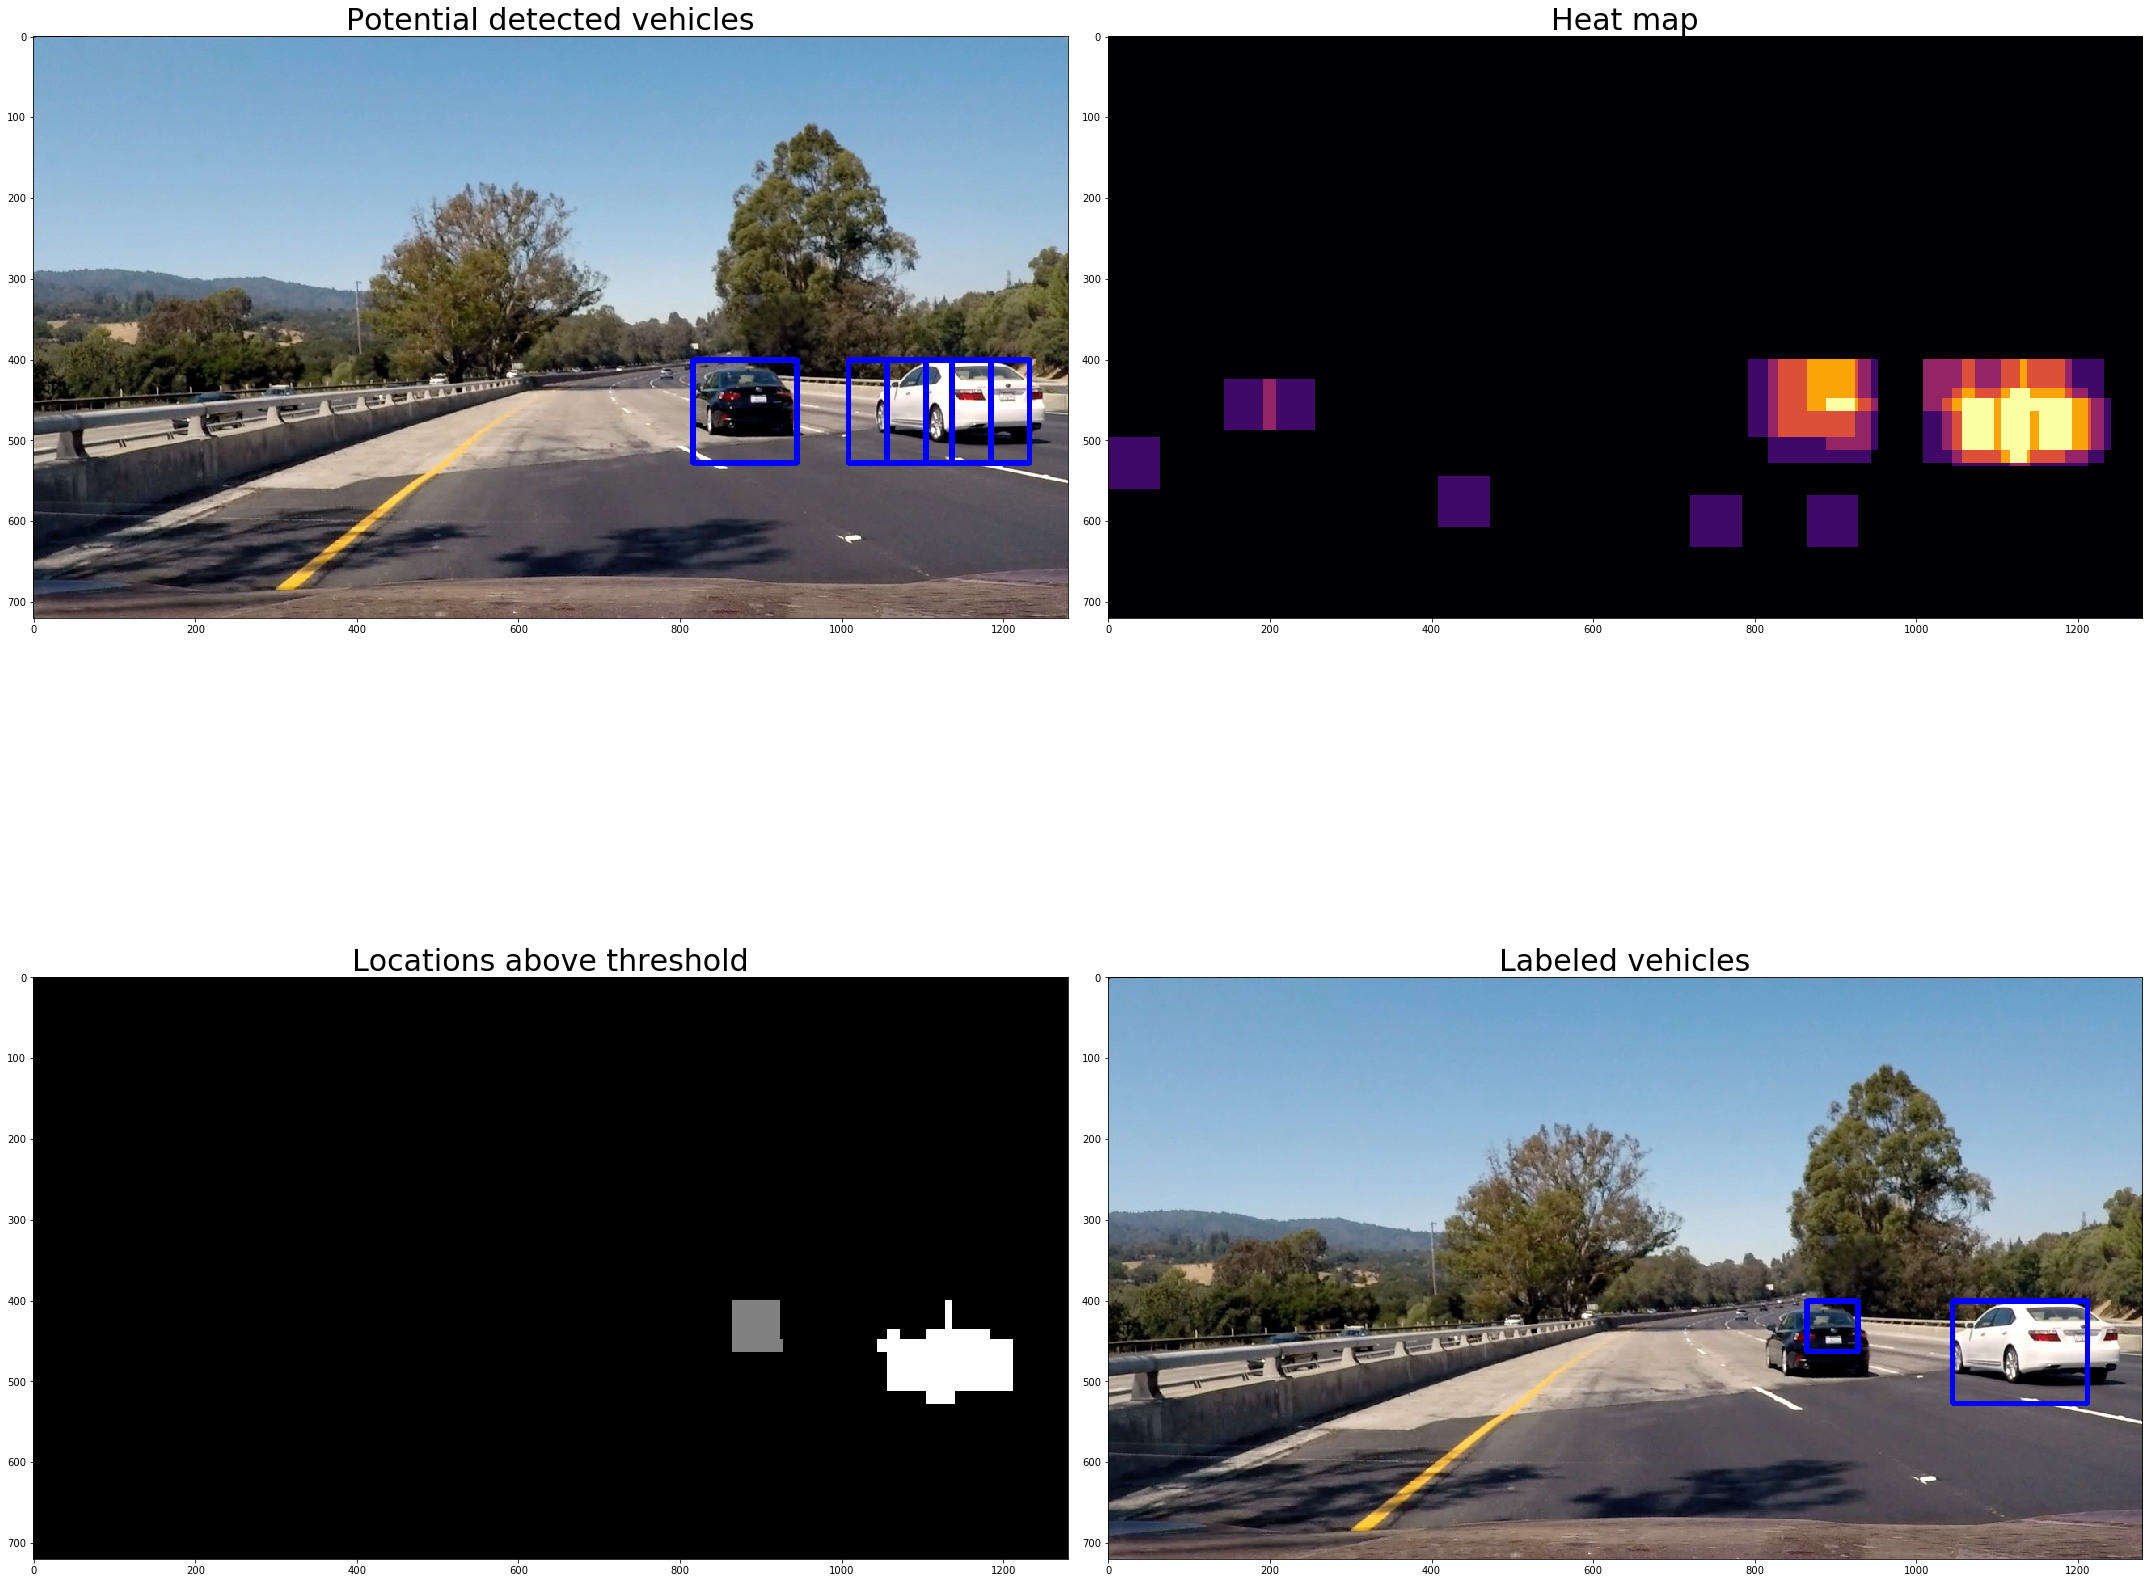

2 cars found


In [8]:
# Test the find_cars() function and create images for writeup
ystart = 400
ystop = 656


from scipy.ndimage.measurements import label

img = mpimg.imread('./data/test_images/test4.jpg')

t=time.time()

scale = 2
out_img1, heat_img1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
scale = 1.5
out_img2, heat_img2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
scale = 1.0
out_img3, heat_img3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heat_img = heat_img1+heat_img2+heat_img3
threshold_val = 3


t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC.')


plt.figure(figsize = (30,30))
plt.subplot(2, 2, 1)
plt.title('Potential detected vehicles',fontsize=30)
plt.imshow(out_img1)

plt.subplot(2, 2, 2)
plt.imshow(heat_img, cmap='inferno', vmin=0, vmax=5)
plt.title('Heat map',fontsize=30)

heat_thresh_img = apply_threshold(heat_img, threshold_val)
labels = label(heat_thresh_img)
img_labeled = draw_labeled_bboxes(img, labels)

plt.subplot(2, 2, 3)
plt.imshow(labels[0], cmap='gray')
plt.title('Locations above threshold',fontsize=30)

plt.subplot(2, 2, 4)
plt.imshow(img_labeled)
plt.title('Labeled vehicles',fontsize=30)

plt.tight_layout()
plt.show()

print(labels[1], 'cars found')

In [9]:
global heat_img_array
heat_img_array = []

def process_vehicle_overlay(img):
    """Processes a single frame from video. Uses the same sliding window search as above
    however also uses a buffer of past heatmaps to mitigate potential false positives"""

    scale = 3
    heat_img1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    scale = 2
    heat_img2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    scale = 1.0
    heat_img3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)

    heat_img = heat_img1+heat_img2+heat_img3
    
    global heat_img_array
    
    heat_img_array.append(heat_img)
    if(len(heat_img_array)>10):
        heat_img_array = heat_img_array[1:-1]
    
    heat_img = sum(heat_img_array)
    
    threshold_val = 14
    heat_thresh_img = apply_threshold(heat_img, threshold_val)
    labels = label(heat_thresh_img)

    img_labeled = draw_labeled_bboxes(img, labels)
    return img_labeled


In [10]:
#video test
# run the movie files after images are working
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#video_unprocessed = VideoFileClip("../project_video.mp4").subclip(0,15)
video_unprocessed = VideoFileClip("./data/test_videos/project_video.mp4").subclip(10,15)
video_processed = video_unprocessed.fl_image(process_vehicle_overlay) 

video_output = './output_videos/project_video_output_short2.mp4'
%time video_processed.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))



C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



MoviePy: building video file ./output_videos/project_video_output_short2.mp4
----------------------------------------

Writing video into ./output_videos/project_video_output_short2.mp4


  0%|                                                  | 0/121 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
 99%|███████████████████████████████████████▋| 120/121 [09:49<00:04,  4.88s/it]


Done writing video in ./output_videos/project_video_output_short2.mp4 !
Your video is ready !
Wall time: 9min 50s
